In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import scipy.stats as stats
import matplotlib.pyplot as plt

# Step 0: Web scrap price data
symbols = ['MSFT', 'AAPL', 'NVDA', 'LRCX', 'AMZN', 'GOOGL', 'TSLA']
start_date = '2015-03-21'
end_date = '2022-02-01'

prices_df = pd.DataFrame()
for symbol in symbols:
    ticker = yf.Ticker(symbol)
    df = ticker.history(start=start_date, end=end_date)
    prices_df[symbol] = df['Close']

# Step 1: Construct a portfolio of equal weights
weights = np.array([1/len(symbols)]*len(symbols))
portfolio_df = prices_df.dot(weights)

# Step 2: Compute daily return of the portfolio
returns_df = portfolio_df.pct_change().dropna()

# Step 3: Prepare inputs for the Pearson system
mean = np.mean(returns_df)
std_dev = np.std(returns_df)
skewness = stats.skew(returns_df)
kurtosis = stats.kurtosis(returns_df)

# Step 4: Model the portfolio return PDF by the Pearson system
pearson_params = stats.pearson3.fit(returns_df)

# Step 5: Generate 1000 samples from the model
samples = stats.pearson3.rvs(*pearson_params, size=1000)

/tmp/ipykernel_3572068/3340363911.py:7: RuntimeWarning: invalid value encountered in log
  g = np.sum(np.log(1 + f*samples))/len(samples)


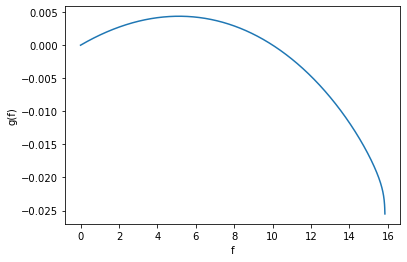

The optimal leverage:  5.13


In [31]:
# Step 6: Plot g(f)
f_values = np.arange(0, 21, 0.01)
g_values = []
g_max=float('-inf')
f_max=-1
for f in f_values:
    g = np.sum(np.log(1 + f*samples))/len(samples)
    if g>g_max:
        g_max=g
        f_max=f
    g_values.append(g)

plt.plot(f_values, g_values)
plt.xlabel('f')
plt.ylabel('g(f)')
plt.show()
print('The optimal leverage: ',f_max)